In [5]:
import uproot
from tqdm import tqdm
import numpy as np

# txt files from
# https://doi.org/10.57760/sciencedb.16322

In [7]:
def read_root_file(filename, max_tags = 300):
    # Open the file and access the TTree
    with uproot.open(filename) as file:
        tree = file["sim"]

        # Load branches
        wf_i = tree["wf_i"].array(library="np")
        mom = tree["mom"].array(library="np")
        time = tree["time"].array(library="np")
        tag = tree["tag"].array(library="np")

        n_events = len(wf_i)

        # Preallocate output array
        result_dtype = np.dtype([
            ("wf_i", np.float32, (3000,)),
            ("mom", np.float32),
            ("tag_times", np.int32, (max_tags,)),
            ("tag_values", np.int32, (max_tags,))
        ])
        result = np.zeros(n_events, dtype=result_dtype)

        for i in range(n_events):
            result[i]["wf_i"] = wf_i[i]
            result[i]["mom"] = mom[i]

            tag_indices = np.where(tag[i] > 0)[0]
            n_tags = min(len(tag_indices), max_tags)

            # Fill the actual values, rest remains zero
            result[i]["tag_times"][:n_tags] = time[i][tag_indices[:n_tags]]
            result[i]["tag_values"][:n_tags] = tag[i][tag_indices[:n_tags]]

    return result

def process_multiple_files(file_list, output_file, max_tags = 300):
    all_data = []

    for filename in file_list:
        print(f"Processing: {filename}")
        data = read_root_file(filename, max_tags)
        all_data.append(data)

    combined_data = np.concatenate(all_data)
    np.savez_compressed(output_file, 
                        wf_i = combined_data['wf_i'],
                        mom = combined_data['mom'],
                        tag_times = combined_data['tag_times'],
                        tag_values = combined_data['tag_values'],)
    print(f"Saved combined data to {output_file}")

    return combined_data

In [9]:
import os
import numpy as np
import requests
from pathlib import Path
from tqdm import tqdm

from urllib.parse import urlparse, parse_qs

def get_filename_from_url(url):
    query = parse_qs(urlparse(url).query)
    return query.get('fileName', [os.path.basename(urlparse(url).path)])[0]

def download_file(url, output_dir):
    filename = get_filename_from_url(url)
    local_path = os.path.join(output_dir, filename)

    if os.path.exists(local_path):
        print(f"File already exists: {local_path}")
        return local_path

    try:
        with requests.get(url, stream=True, timeout=60) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('Content-Length', 0))
            block_size = 1024 * 1024  # 1 MB
            use_total = total_size > 0

            desc = filename[:40] + ("..." if len(filename) > 40 else "")
            t = tqdm(total=total_size if use_total else None,
                     unit='iB', unit_scale=True, desc=desc)

            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=block_size):
                    if chunk:
                        f.write(chunk)
                        t.update(len(chunk))
            t.close()

        return local_path
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return None

def process_in_batches(url_file, output_dir, batch_size, max_tags):
    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Read all URLs
    with open(url_file, 'r') as f:
        urls = [line.strip() for line in f if line.strip()]

    # Process in batches
    for i in range(0, len(urls), batch_size):
        batch_urls = urls[i:i+batch_size]
        local_files = []

        print(f"Processing batch {i // batch_size + 1}...")
        for url in batch_urls:
            local_path = download_file(url, output_dir)
            local_files.append(local_path)

        npz_name = os.path.join(output_dir, f"batch_{i // batch_size}.npz")
        data = process_multiple_files(local_files, npz_name, max_tags)

        # Clean up downloaded root files
        for fpath in local_files:
            os.remove(fpath)

        print(f"Saved {npz_name} and deleted temporary root files.\n")

    return data

In [11]:
max_tags = 300

data = process_in_batches("./peakfind_train.txt", "processed_data_train", batch_size=10, max_tags=300)

Processing batch 1...


signal_noise05_PFtrain_20.root: 100%|███████| 403M/403M [00:55<00:00, 7.21MiB/s]
signal_noise05_PFtrain_11.root: 100%|███████| 403M/403M [01:04<00:00, 6.20MiB/s]
signal_noise05_PFtrain_18.root: 100%|███████| 403M/403M [00:45<00:00, 8.92MiB/s]
signal_noise05_PFtrain_34.root: 100%|███████| 403M/403M [00:46<00:00, 8.75MiB/s]
signal_noise05_PFtrain_12.root: 100%|███████| 403M/403M [00:59<00:00, 6.76MiB/s]
signal_noise05_PFtrain_44.root: 100%|███████| 403M/403M [00:45<00:00, 8.83MiB/s]
signal_noise05_PFtrain_9.root: 100%|████████| 403M/403M [01:07<00:00, 5.95MiB/s]
signal_noise05_PFtrain_5.root: 100%|████████| 403M/403M [00:55<00:00, 7.29MiB/s]
signal_noise05_PFtrain_10.root: 100%|███████| 403M/403M [00:48<00:00, 8.37MiB/s]
signal_noise05_PFtrain_8.root: 100%|████████| 403M/403M [00:48<00:00, 8.36MiB/s]


Processing: processed_data_train/signal_noise05_PFtrain_20.root
Processing: processed_data_train/signal_noise05_PFtrain_11.root
Processing: processed_data_train/signal_noise05_PFtrain_18.root
Processing: processed_data_train/signal_noise05_PFtrain_34.root
Processing: processed_data_train/signal_noise05_PFtrain_12.root
Processing: processed_data_train/signal_noise05_PFtrain_44.root
Processing: processed_data_train/signal_noise05_PFtrain_9.root
Processing: processed_data_train/signal_noise05_PFtrain_5.root
Processing: processed_data_train/signal_noise05_PFtrain_10.root
Processing: processed_data_train/signal_noise05_PFtrain_8.root
Saved combined data to processed_data_train/batch_0.npz
Saved processed_data_train/batch_0.npz and deleted temporary root files.

Processing batch 2...


signal_noise05_PFtrain_16.root: 100%|███████| 403M/403M [00:53<00:00, 7.49MiB/s]
signal_noise05_PFtrain_41.root: 100%|███████| 403M/403M [00:46<00:00, 8.72MiB/s]
signal_noise05_PFtrain_6.root: 100%|████████| 403M/403M [00:48<00:00, 8.22MiB/s]
signal_noise05_PFtrain_37.root: 100%|███████| 403M/403M [00:47<00:00, 8.50MiB/s]
signal_noise05_PFtrain_47.root: 100%|███████| 403M/403M [00:49<00:00, 8.13MiB/s]
signal_noise05_PFtrain_42.root: 100%|███████| 403M/403M [00:47<00:00, 8.42MiB/s]
signal_noise05_PFtrain_25.root: 100%|███████| 403M/403M [00:47<00:00, 8.52MiB/s]
signal_noise05_PFtrain_27.root: 100%|███████| 403M/403M [00:45<00:00, 8.90MiB/s]
signal_noise05_PFtrain_30.root: 100%|███████| 403M/403M [00:47<00:00, 8.40MiB/s]
signal_noise05_PFtrain_28.root: 100%|███████| 403M/403M [00:46<00:00, 8.74MiB/s]


Processing: processed_data_train/signal_noise05_PFtrain_16.root
Processing: processed_data_train/signal_noise05_PFtrain_41.root
Processing: processed_data_train/signal_noise05_PFtrain_6.root
Processing: processed_data_train/signal_noise05_PFtrain_37.root
Processing: processed_data_train/signal_noise05_PFtrain_47.root
Processing: processed_data_train/signal_noise05_PFtrain_42.root
Processing: processed_data_train/signal_noise05_PFtrain_25.root
Processing: processed_data_train/signal_noise05_PFtrain_27.root
Processing: processed_data_train/signal_noise05_PFtrain_30.root
Processing: processed_data_train/signal_noise05_PFtrain_28.root
Saved combined data to processed_data_train/batch_1.npz
Saved processed_data_train/batch_1.npz and deleted temporary root files.

Processing batch 3...


signal_noise05_PFtrain_0.root: 100%|████████| 403M/403M [00:50<00:00, 7.93MiB/s]
signal_noise05_PFtrain_1.root: 100%|████████| 403M/403M [00:42<00:00, 9.50MiB/s]
signal_noise05_PFtrain_46.root: 100%|███████| 403M/403M [00:42<00:00, 9.53MiB/s]
signal_noise05_PFtrain_19.root: 100%|███████| 403M/403M [00:42<00:00, 9.50MiB/s]
signal_noise05_PFtrain_14.root: 100%|███████| 403M/403M [00:52<00:00, 7.62MiB/s]
signal_noise05_PFtrain_38.root: 100%|███████| 403M/403M [00:51<00:00, 7.86MiB/s]
signal_noise05_PFtrain_49.root: 100%|███████| 403M/403M [00:53<00:00, 7.55MiB/s]
signal_noise05_PFtrain_24.root: 100%|███████| 403M/403M [00:48<00:00, 8.35MiB/s]
signal_noise05_PFtrain_31.root: 100%|███████| 403M/403M [00:47<00:00, 8.41MiB/s]
signal_noise05_PFtrain_15.root: 100%|███████| 403M/403M [00:50<00:00, 7.99MiB/s]


Processing: processed_data_train/signal_noise05_PFtrain_0.root
Processing: processed_data_train/signal_noise05_PFtrain_1.root
Processing: processed_data_train/signal_noise05_PFtrain_46.root
Processing: processed_data_train/signal_noise05_PFtrain_19.root
Processing: processed_data_train/signal_noise05_PFtrain_14.root
Processing: processed_data_train/signal_noise05_PFtrain_38.root
Processing: processed_data_train/signal_noise05_PFtrain_49.root
Processing: processed_data_train/signal_noise05_PFtrain_24.root
Processing: processed_data_train/signal_noise05_PFtrain_31.root
Processing: processed_data_train/signal_noise05_PFtrain_15.root
Saved combined data to processed_data_train/batch_2.npz
Saved processed_data_train/batch_2.npz and deleted temporary root files.

Processing batch 4...


signal_noise05_PFtrain_40.root: 100%|███████| 403M/403M [01:00<00:00, 6.71MiB/s]
signal_noise05_PFtrain_32.root: 100%|███████| 403M/403M [00:45<00:00, 8.87MiB/s]
signal_noise05_PFtrain_13.root: 100%|███████| 403M/403M [00:44<00:00, 8.98MiB/s]
signal_noise05_PFtrain_33.root: 100%|███████| 403M/403M [00:47<00:00, 8.39MiB/s]
signal_noise05_PFtrain_48.root: 100%|███████| 403M/403M [00:51<00:00, 7.81MiB/s]
signal_noise05_PFtrain_45.root: 100%|███████| 403M/403M [00:46<00:00, 8.69MiB/s]
signal_noise05_PFtrain_17.root: 100%|███████| 403M/403M [00:45<00:00, 8.82MiB/s]
signal_noise05_PFtrain_35.root: 100%|███████| 403M/403M [00:57<00:00, 7.02MiB/s]
signal_noise05_PFtrain_21.root: 100%|███████| 403M/403M [00:46<00:00, 8.57MiB/s]
signal_noise05_PFtrain_36.root: 100%|███████| 403M/403M [00:45<00:00, 8.82MiB/s]


Processing: processed_data_train/signal_noise05_PFtrain_40.root
Processing: processed_data_train/signal_noise05_PFtrain_32.root
Processing: processed_data_train/signal_noise05_PFtrain_13.root
Processing: processed_data_train/signal_noise05_PFtrain_33.root
Processing: processed_data_train/signal_noise05_PFtrain_48.root
Processing: processed_data_train/signal_noise05_PFtrain_45.root
Processing: processed_data_train/signal_noise05_PFtrain_17.root
Processing: processed_data_train/signal_noise05_PFtrain_35.root
Processing: processed_data_train/signal_noise05_PFtrain_21.root
Processing: processed_data_train/signal_noise05_PFtrain_36.root
Saved combined data to processed_data_train/batch_3.npz
Saved processed_data_train/batch_3.npz and deleted temporary root files.

Processing batch 5...


signal_noise05_PFtrain_26.root: 100%|███████| 403M/403M [00:55<00:00, 7.21MiB/s]
signal_noise05_PFtrain_3.root: 100%|████████| 403M/403M [00:54<00:00, 7.41MiB/s]
signal_noise05_PFtrain_22.root: 100%|███████| 403M/403M [01:05<00:00, 6.19MiB/s]
signal_noise05_PFtrain_7.root: 100%|████████| 403M/403M [00:56<00:00, 7.17MiB/s]
signal_noise05_PFtrain_23.root: 100%|███████| 403M/403M [00:55<00:00, 7.28MiB/s]
signal_noise05_PFtrain_39.root: 100%|███████| 403M/403M [00:51<00:00, 7.82MiB/s]
signal_noise05_PFtrain_29.root: 100%|███████| 403M/403M [00:55<00:00, 7.31MiB/s]
signal_noise05_PFtrain_2.root: 100%|████████| 403M/403M [00:53<00:00, 7.56MiB/s]
signal_noise05_PFtrain_43.root: 100%|███████| 403M/403M [00:52<00:00, 7.73MiB/s]
signal_noise05_PFtrain_4.root: 100%|████████| 403M/403M [00:48<00:00, 8.26MiB/s]


Processing: processed_data_train/signal_noise05_PFtrain_26.root
Processing: processed_data_train/signal_noise05_PFtrain_3.root
Processing: processed_data_train/signal_noise05_PFtrain_22.root
Processing: processed_data_train/signal_noise05_PFtrain_7.root
Processing: processed_data_train/signal_noise05_PFtrain_23.root
Processing: processed_data_train/signal_noise05_PFtrain_39.root
Processing: processed_data_train/signal_noise05_PFtrain_29.root
Processing: processed_data_train/signal_noise05_PFtrain_2.root
Processing: processed_data_train/signal_noise05_PFtrain_43.root
Processing: processed_data_train/signal_noise05_PFtrain_4.root
Saved combined data to processed_data_train/batch_4.npz
Saved processed_data_train/batch_4.npz and deleted temporary root files.



In [13]:
process_in_batches("./peakfind_test.txt", "processed_data_test", batch_size=10, max_tags=300)

Processing batch 1...


signal_noise05_PFtest_6.root: 100%|█████████| 403M/403M [00:46<00:00, 8.67MiB/s]
signal_noise05_PFtest_10.root: 100%|████████| 403M/403M [00:55<00:00, 7.23MiB/s]
signal_noise05_PFtest_15.root: 100%|████████| 403M/403M [00:47<00:00, 8.55MiB/s]
signal_noise05_PFtest_5.root: 100%|█████████| 403M/403M [00:53<00:00, 7.53MiB/s]
signal_noise05_PFtest_22.root: 100%|████████| 403M/403M [00:45<00:00, 8.76MiB/s]
signal_noise05_PFtest_27.root: 100%|████████| 403M/403M [00:46<00:00, 8.59MiB/s]
signal_noise05_PFtest_17.root: 100%|████████| 403M/403M [00:45<00:00, 8.80MiB/s]
signal_noise05_PFtest_45.root: 100%|████████| 403M/403M [00:45<00:00, 8.77MiB/s]
signal_noise05_PFtest_42.root: 100%|████████| 403M/403M [00:46<00:00, 8.70MiB/s]
signal_noise05_PFtest_34.root: 100%|████████| 403M/403M [00:47<00:00, 8.43MiB/s]


Processing: processed_data_test/signal_noise05_PFtest_6.root
Processing: processed_data_test/signal_noise05_PFtest_10.root
Processing: processed_data_test/signal_noise05_PFtest_15.root
Processing: processed_data_test/signal_noise05_PFtest_5.root
Processing: processed_data_test/signal_noise05_PFtest_22.root
Processing: processed_data_test/signal_noise05_PFtest_27.root
Processing: processed_data_test/signal_noise05_PFtest_17.root
Processing: processed_data_test/signal_noise05_PFtest_45.root
Processing: processed_data_test/signal_noise05_PFtest_42.root
Processing: processed_data_test/signal_noise05_PFtest_34.root
Saved combined data to processed_data_test/batch_0.npz
Saved processed_data_test/batch_0.npz and deleted temporary root files.

Processing batch 2...


signal_noise05_PFtest_40.root: 100%|████████| 403M/403M [00:49<00:00, 8.14MiB/s]
signal_noise05_PFtest_31.root: 100%|████████| 403M/403M [00:47<00:00, 8.51MiB/s]
signal_noise05_PFtest_43.root: 100%|████████| 403M/403M [00:46<00:00, 8.60MiB/s]
signal_noise05_PFtest_49.root: 100%|████████| 403M/403M [00:49<00:00, 8.14MiB/s]
signal_noise05_PFtest_13.root: 100%|████████| 403M/403M [00:47<00:00, 8.52MiB/s]
signal_noise05_PFtest_9.root: 100%|█████████| 403M/403M [00:46<00:00, 8.74MiB/s]
signal_noise05_PFtest_48.root: 100%|████████| 403M/403M [01:06<00:00, 6.10MiB/s]
signal_noise05_PFtest_25.root: 100%|████████| 403M/403M [00:48<00:00, 8.32MiB/s]
signal_noise05_PFtest_39.root: 100%|████████| 403M/403M [00:54<00:00, 7.36MiB/s]
signal_noise05_PFtest_24.root: 100%|████████| 403M/403M [00:47<00:00, 8.49MiB/s]


Processing: processed_data_test/signal_noise05_PFtest_40.root
Processing: processed_data_test/signal_noise05_PFtest_31.root
Processing: processed_data_test/signal_noise05_PFtest_43.root
Processing: processed_data_test/signal_noise05_PFtest_49.root
Processing: processed_data_test/signal_noise05_PFtest_13.root
Processing: processed_data_test/signal_noise05_PFtest_9.root
Processing: processed_data_test/signal_noise05_PFtest_48.root
Processing: processed_data_test/signal_noise05_PFtest_25.root
Processing: processed_data_test/signal_noise05_PFtest_39.root
Processing: processed_data_test/signal_noise05_PFtest_24.root
Saved combined data to processed_data_test/batch_1.npz
Saved processed_data_test/batch_1.npz and deleted temporary root files.

Processing batch 3...


signal_noise05_PFtest_46.root: 100%|████████| 403M/403M [00:47<00:00, 8.44MiB/s]
signal_noise05_PFtest_36.root: 100%|████████| 403M/403M [00:47<00:00, 8.45MiB/s]
signal_noise05_PFtest_4.root: 100%|█████████| 403M/403M [00:45<00:00, 8.80MiB/s]
signal_noise05_PFtest_33.root: 100%|████████| 403M/403M [00:45<00:00, 8.87MiB/s]
signal_noise05_PFtest_47.root: 100%|████████| 403M/403M [00:44<00:00, 8.96MiB/s]
signal_noise05_PFtest_2.root: 100%|█████████| 403M/403M [00:45<00:00, 8.91MiB/s]
signal_noise05_PFtest_29.root: 100%|████████| 403M/403M [00:47<00:00, 8.54MiB/s]
signal_noise05_PFtest_21.root: 100%|████████| 403M/403M [00:49<00:00, 8.06MiB/s]
signal_noise05_PFtest_32.root: 100%|████████| 403M/403M [00:46<00:00, 8.58MiB/s]
signal_noise05_PFtest_0.root: 100%|█████████| 403M/403M [00:46<00:00, 8.73MiB/s]


Processing: processed_data_test/signal_noise05_PFtest_46.root
Processing: processed_data_test/signal_noise05_PFtest_36.root
Processing: processed_data_test/signal_noise05_PFtest_4.root
Processing: processed_data_test/signal_noise05_PFtest_33.root
Processing: processed_data_test/signal_noise05_PFtest_47.root
Processing: processed_data_test/signal_noise05_PFtest_2.root
Processing: processed_data_test/signal_noise05_PFtest_29.root
Processing: processed_data_test/signal_noise05_PFtest_21.root
Processing: processed_data_test/signal_noise05_PFtest_32.root
Processing: processed_data_test/signal_noise05_PFtest_0.root
Saved combined data to processed_data_test/batch_2.npz
Saved processed_data_test/batch_2.npz and deleted temporary root files.

Processing batch 4...


signal_noise05_PFtest_38.root: 100%|████████| 403M/403M [00:46<00:00, 8.67MiB/s]
signal_noise05_PFtest_16.root: 100%|████████| 403M/403M [00:46<00:00, 8.69MiB/s]
signal_noise05_PFtest_12.root: 100%|████████| 403M/403M [00:52<00:00, 7.71MiB/s]
signal_noise05_PFtest_26.root: 100%|████████| 403M/403M [00:49<00:00, 8.10MiB/s]
signal_noise05_PFtest_44.root: 100%|████████| 403M/403M [00:55<00:00, 7.31MiB/s]
signal_noise05_PFtest_28.root: 100%|████████| 403M/403M [00:50<00:00, 7.90MiB/s]
signal_noise05_PFtest_14.root: 100%|████████| 403M/403M [00:50<00:00, 7.96MiB/s]
signal_noise05_PFtest_11.root: 100%|████████| 403M/403M [00:46<00:00, 8.69MiB/s]
signal_noise05_PFtest_35.root: 100%|████████| 403M/403M [00:47<00:00, 8.54MiB/s]
signal_noise05_PFtest_19.root: 100%|████████| 403M/403M [00:46<00:00, 8.67MiB/s]


Processing: processed_data_test/signal_noise05_PFtest_38.root
Processing: processed_data_test/signal_noise05_PFtest_16.root
Processing: processed_data_test/signal_noise05_PFtest_12.root
Processing: processed_data_test/signal_noise05_PFtest_26.root
Processing: processed_data_test/signal_noise05_PFtest_44.root
Processing: processed_data_test/signal_noise05_PFtest_28.root
Processing: processed_data_test/signal_noise05_PFtest_14.root
Processing: processed_data_test/signal_noise05_PFtest_11.root
Processing: processed_data_test/signal_noise05_PFtest_35.root
Processing: processed_data_test/signal_noise05_PFtest_19.root
Saved combined data to processed_data_test/batch_3.npz
Saved processed_data_test/batch_3.npz and deleted temporary root files.

Processing batch 5...


signal_noise05_PFtest_8.root: 100%|█████████| 403M/403M [00:46<00:00, 8.66MiB/s]
signal_noise05_PFtest_37.root: 100%|████████| 403M/403M [00:46<00:00, 8.75MiB/s]
signal_noise05_PFtest_18.root: 100%|████████| 403M/403M [00:49<00:00, 8.22MiB/s]
signal_noise05_PFtest_7.root: 100%|█████████| 403M/403M [00:48<00:00, 8.23MiB/s]
signal_noise05_PFtest_23.root: 100%|████████| 403M/403M [00:46<00:00, 8.63MiB/s]
signal_noise05_PFtest_3.root: 100%|█████████| 403M/403M [00:51<00:00, 7.78MiB/s]
signal_noise05_PFtest_30.root: 100%|████████| 403M/403M [00:47<00:00, 8.54MiB/s]
signal_noise05_PFtest_1.root: 100%|█████████| 403M/403M [00:46<00:00, 8.66MiB/s]
signal_noise05_PFtest_41.root: 100%|████████| 403M/403M [00:45<00:00, 8.76MiB/s]
signal_noise05_PFtest_20.root: 100%|████████| 403M/403M [00:47<00:00, 8.40MiB/s]


Processing: processed_data_test/signal_noise05_PFtest_8.root
Processing: processed_data_test/signal_noise05_PFtest_37.root
Processing: processed_data_test/signal_noise05_PFtest_18.root
Processing: processed_data_test/signal_noise05_PFtest_7.root
Processing: processed_data_test/signal_noise05_PFtest_23.root
Processing: processed_data_test/signal_noise05_PFtest_3.root
Processing: processed_data_test/signal_noise05_PFtest_30.root
Processing: processed_data_test/signal_noise05_PFtest_1.root
Processing: processed_data_test/signal_noise05_PFtest_41.root
Processing: processed_data_test/signal_noise05_PFtest_20.root
Saved combined data to processed_data_test/batch_4.npz
Saved processed_data_test/batch_4.npz and deleted temporary root files.



array([([-3.54307354e-03, -2.43015252e-02, -2.11635064e-02, ..., -1.30251958e-03,  1.19383797e-01,  1.87852338e-01], 19.994886 , [ 124,  137,  208,  226,  282,  286,  299,  303,  315,  326,  335,  385,  391,  554,  756,  809,  989, 1120, 1190, 1209, 1319, 1337, 1362, 1506, 2998,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 

In [15]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(100000, 3000)
(100000,)
(100000, 300)
(100000, 300)


In [25]:
print(data['wf_i'][0])
#print(data['mom'][0])
#print(data['tag_times'][0])
# print(data['tag_values'][0])

# print(data['tag_mask'][0])

[ 0.01372382 -0.00381347  0.02392138 ...  0.04399255  0.04196985
  0.03770616]


In [27]:
import matplotlib.pyplot as plt

(0.0, 2.366558080166578)

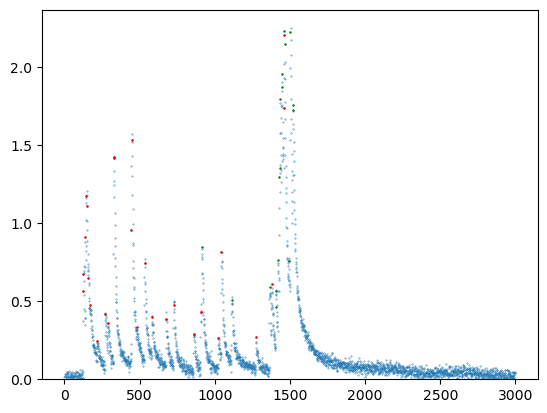

In [29]:
iev = 0
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=0.1);
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=0.6,color='r')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=0.4,color='g')
plt.ylim(0)

(0.0, 1.9806983549147845)

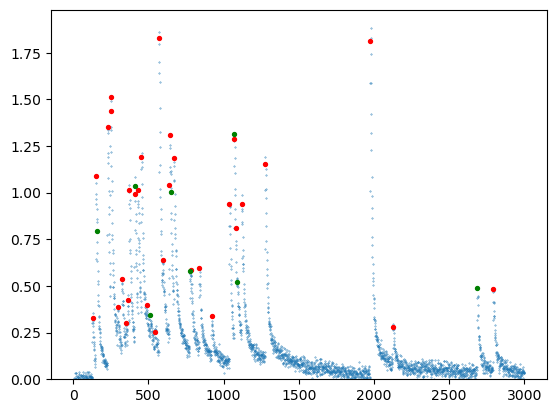

In [41]:
iev = 10
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=0.1);
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=8.0,color='r')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=8.0,color='g')
plt.ylim(0)

In [ ]:
iev = 30
plt.scatter(np.arange(data['wf_i'][iev].shape[0]),data['wf_i'][iev],s=0.1);
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==1],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==1]],s=0.6,color='r')
plt.scatter(data['tag_times'][iev,data['tag_values'][iev]==2],data['wf_i'][iev][data['tag_times'][iev,data['tag_values'][iev]==2]],s=0.4,color='g')
plt.ylim(0)